# Puffin Beam Conditioner

This notebook will guide you through the process of converting an electron beam distribution from an external source (e.g. an external accelerator code) into Puffin. The distribution is re-conditioned to obey the expected noise characteristics relevant to the start-up process in SASE in a FEL.

If the beam has been generated in a "one-to-one" simulation (meaning, the simulation was performed with real electrons), then this MAY not need to be done.

This noteboook has been converted from the original Python script by Piotr T.

In [45]:
%matplotlib inline
import numpy as np
import tables
import sys
import time
import datetime
import matplotlib.pyplot as plt
from scipy import interpolate

now = datetime.datetime.now()
print 'Current time: ',now.strftime("%Y-%m-%d %H:%M:%S")


file_name_in = 'test_1kSI.si5'

file_name_base  = (file_name_in.split('.')[0]).strip()




Current time:  2016-09-05 13:47:14


## Physical Constants

In [46]:
e_ch=1.602e-19
Pi=3.1415
k_u=157.075
a_u=1
c=2.99792458e+8
m=9.11e-31
e_0=8.854E-12 



# Open file, assign particles

f=tables.open_file(file_name_in,'r')
Particles=f.root.Particles.read()
mA_X = Particles[:,0]
mA_Y = Particles[:,2]    
mA_Z = Particles[:,4]
mA_PX = Particles[:,1]
mA_PY = Particles[:,3]  
mA_PZ = Particles[:,5]
mA_WGHT = Particles[:,6]






################################################
# FEL characteristics


# Get peak spatial density of input beam

xyz = np.vstack([mA_X,mA_Y,mA_Z]).T
size_x=max(mA_X)-min(mA_X)
size_y=max(mA_Y)-min(mA_Y)
size_z=max(mA_Z)-min(mA_Z)
binnumber=6
cube_volume=(size_x*size_y*size_z)/float(binnumber**3)




H, edges = np.histogramdd(xyz, bins = (binnumber,binnumber,binnumber),normed=False,weights=mA_WGHT.flat)
print H.shape

n_p=float(np.amax(H))/cube_volume


# Derive FEL parameters from the input beam

p_tot=np.sqrt((mA_PX[:]**2)+(mA_PY[:]**2)+(mA_PZ[:]**2))
gamma=(np.sqrt(1+(p_tot/(m*c))**2))
gamma_0=np.mean(gamma)
omega_p=np.sqrt((e_ch*e_ch*n_p)/(e_0*m))
rho=(1/gamma_0)*(((a_u*omega_p)/(4*c*k_u))**(2.0/3.0))
lambda_u=(2*Pi)/k_u
lambda_r=(lambda_u/(2*gamma_0**2))*(1+a_u**2)
Lg = lambda_u / (4*Pi*rho)
Lc=lambda_r/(4*Pi*rho)




print 'Peak density = ', n_p, '(Number of electrons per meter cubed)'
print 'Mean beam energy (Lorentz factor)= ', gamma_0
print 'FEL parameter rho = ', rho
print 'RMS undulator parameter = ', a_u
print 'Wiggler period = ', lambda_u, '(m)'
print 'Resonant wavelength = ', lambda_r, '(m)'
print 'Gain length = ', Lg, '(m)'
print 'Cooperation length = ', Lc, '(m)'




(6, 6, 6)
Peak density =  6.28084339162e+19 (Number of electrons per meter cubed)
Mean beam energy (Lorentz factor)=  100.420116816
FEL parameter rho =  0.0177180450066
RMS undulator parameter =  1
Wiggler period =  0.04 (m)
Resonant wavelength =  3.96660127226e-06 (m)
Gain length =  0.179658237754 (m)
Cooperation length =  1.78158148611e-05 (m)


Binnumber X,Y,Z =  10 10 10
Charge in beam =  4.518441e-09
Number of source macroparticles:  1000
(1000, 2) (1000, 2)
(10,) (11,)


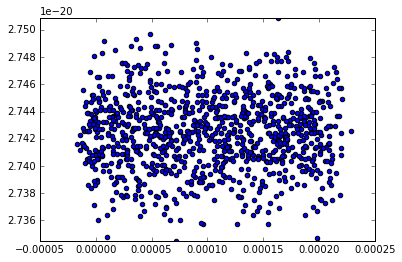

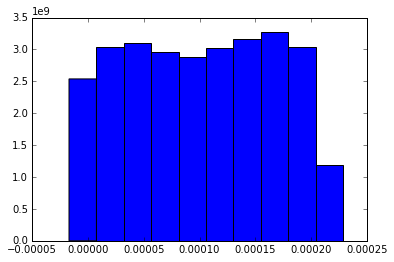

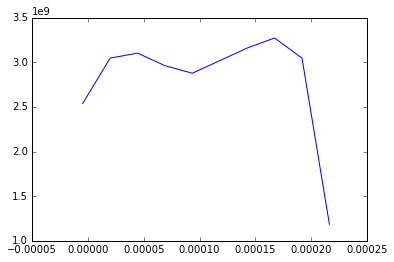

In [58]:
# number_of_bins=int((size_z/Lc)*1.10)
number_of_bins=10




binnumber_Z = number_of_bins  
binnumber_X = 10  # Lawrence changed this part
binnumber_Y = 10  # Lawrence changed this part

print'Binnumber X,Y,Z = ',binnumber_X,binnumber_Y,binnumber_Z




xyzW = np.vstack((mA_X.flat,mA_Y.flat,mA_Z.flat,mA_WGHT.flat)).T

xyzW = xyzW[xyzW[:,2].argsort()]






mB_X=xyzW[:,0].flat
mB_Y=xyzW[:,1].flat
mB_Z=xyzW[:,2].flat
mB_WGHT=xyzW[:,3].flat


# Set the multiplier of desired particle number
# The higher the number the more time it will take
# Please not that if you set this too high the algorithm will still work
# but at the end your particles will have smaller than one what means that 
# you have less than one electron per particle
# Currently there is no safety mechanism to avoid this
DensityFactor=1000


#Calculate total charge
TotalNumberOfElectrons=np.sum(mA_WGHT)
ch_tot = TotalNumberOfElectrons*e_ch
print 'Charge in beam = ',ch_tot
print 'Number of source macroparticles: ',len(mB_X)

# Set desired particle number per slice - best to set the number that will give 
# an integer when total number of source particles will be divided over it
# Otherwise your particles will be cut at the end
# Very low number can give weird results

 
m_X=mB_X[:]
m_Y=mB_Y[:]
m_Z=mB_Z[:]
m_WGHT=mB_WGHT[:]
          
m_Xm_Z=np.vstack((mA_X.flat,mA_Z.flat)).T
m_Ym_Z=np.vstack((mA_Y.flat,mA_Z.flat)).T
print np.shape(m_Xm_Z),np.shape(m_Ym_Z)




Hz, edges_Z = np.histogram(m_Z, bins = binnumber_Z,normed=False,weights=m_WGHT.flat)

print np.shape(Hz),np.shape(edges_Z)


#Hz, edges_Z = np.histogramdd(m_Z, bins = binnumber_Z,normed=False,weights=m_WGHT.flat)
#Hy, edges_Y = np.histogramdd(m_Y, bins = binnumber_Y,normed=False,weights=m_WGHT.flat)
#Hx, edges_X = np.histogramdd(m_X, bins = binnumber_X,normed=False,weights=m_WGHT.flat)


#HxHz,edges_XZ = np.histogramdd(m_Xm_Z, bins = (binnumber_X,binnumber_Z),normed=False,weights=m_WGHT.flat)
#HyHz,edges_YZ = np.histogramdd(m_Ym_Z, bins = (binnumber_Y,binnumber_Z),normed=False,weights=m_WGHT.flat)



#data= np.vstack((m_X.ravel(),m_Z.ravel())).T
#x, y = data.T
#nbins=20
#k = kde.gaussian_kde(data.T,weights=mB_WGHT[:])
#xi, yi = np.mgrid[x.min():x.max():nbins*1j, y.min():y.max():nbins*1j]
#zi = k(np.vstack([xi.flatten(), yi.flatten()]))
#plt.pcolormesh(xi, yi, zi.reshape(xi.shape))
#plt.show()

#XZarr=np.zeros(((len(edges_XZ[0])-1)*(len(edges_XZ[1])-1),3))
#YZarr=np.zeros(((len(edges_YZ[0])-1)*(len(edges_YZ[1])-1),3))

plt.scatter(mA_Z, mA_PZ)
axes = plt.gca()
# axes.set_xlim([min(mA_Z),max(mA_Z)])
axes.set_ylim([min(mA_PZ),max(mA_PZ)])
axes.set_xlim(-0.00005,0.00025)
plt.show()

plt.hist(m_Z, bins = binnumber_Z,normed=False,weights=m_WGHT.flat)
plt.show()

dz = edges_Z[1] - edges_Z[0]
pts_z = edges_Z + 0.5*dz
pts_z = pts_z[0:-1]

plt.plot(pts_z, Hz)
plt.show()



Now we have the raw input data and a histogram. We use this to get an interpolated function of the input. You can choose here which kind of interpolation you need. If your histogram (in other words, the current) is spiky, then you probably want to use the LSQ splines to smooth it out. Otherwise, if it seems smooth enough already, use the cubic. The preview should guide you:

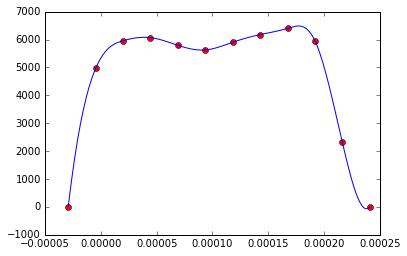

In [59]:
# Interpolate density along Z-axis
#x0_Z = np.linspace(np.min(m_Z),np.max(m_Z),binnumber_Z)
#x0_Z = np.linspace(0.5*(edges_Z[0][0]+edges_Z[0][1]),0.5*(edges_Z[0][binnumber_Z]+edges_Z[0][binnumber_Z-1]),binnumber_Z)

#y0_Z = Hz

#z_hstgrm_length=0.5*(edges_Z[0][binnumber_Z]+edges_Z[0][binnumber_Z-1])-0.5*(edges_Z[0][0]+edges_Z[0][1])

#t_knots_z=[min(x0_Z)+0.1*z_hstgrm_length,min(x0_Z)+0.25*z_hstgrm_length,np.mean(x0_Z),max(x0_Z)-0.25*z_hstgrm_length,max(x0_Z)-0.1*z_hstgrm_length]
#t_knots_z=[edges_Z[0][0]+0.1*z_hstgrm_length,edges_Z[0][0]+0.25*z_hstgrm_length,(edges_Z[0][binnumber_Z]+edges_Z[0][0])*0.5,edges_Z[0][binnumber_Z]-0.25*z_hstgrm_length,edges_Z[0][binnumber_Z]-0.1*z_hstgrm_length]
#t_knots_z=[edges_Z[0][0]+0.25*z_hstgrm_length,edges_Z[0][binnumber_Z]-0.25*z_hstgrm_length]
# f_Z = interpolate.LSQUnivariateSpline(x0_Z, y0_Z,t_knots_z,ext=0)


#pts_z = pts_z.append(pts_z[-1] + dz)
#pts_z = array([pts_z[0]-dz]).append(pts_z)

#Hz = array([0]).append(Hz)
#Hz = Hz.append(0)


zstt = pts_z[0]-dz
zedt = pts_z[-1]+dz


pts_z = np.append([zstt], pts_z)
pts_z = np.append(pts_z, [zedt])

Hz = np.append([0], Hz)
Hz = np.append(Hz, [0])


f_Z = interpolate.interp1d(pts_z, Hz, 'cubic')


#f_Z = interpolate.UnivariateSpline(x0_Z, y0_Z,k=5)
#print 0.5*(edges_Z[0][binnumber_Z]+edges_Z[0][binnumber_Z-1]),0.5*(edges_Z[0][0]+edges_Z[0][1])
#print np.min(m_Z),np.max(mA_Z)
znew = np.linspace(pts_z[0], pts_z[-1], 200)
zds = f_Z(znew)

#print np.shape(zds), np.shape(znew)

current_f = zds * e_ch  * c / dz # Functional form of current
current_h = Hz * e_ch  * c / dz # Functional form of current

plt.plot(pts_z, current_h, 'or', znew, current_f, '-')
plt.show()


## Renormalizing the charge

Renormalizing by factor 0.98916791076
Now total renormalized charge is  4.518441e-09


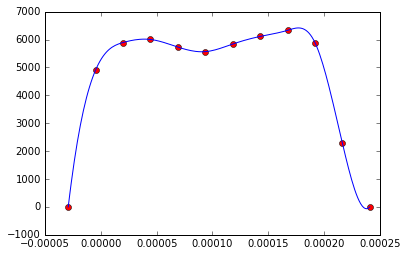

In [60]:
tot_ne_mod = np.trapz(zds/dz, znew)
zds = zds * TotalNumberOfElectrons / tot_ne_mod
Hz = Hz * TotalNumberOfElectrons / tot_ne_mod

print 'Renormalizing by factor', TotalNumberOfElectrons / tot_ne_mod

tot_ne_mod = np.trapz(zds/dz, znew)


print 'Now total renormalized charge is ', tot_ne_mod * e_ch

current_f2 = zds * e_ch  * c / dz # Functional form of current
current_h2 = Hz * e_ch  * c / dz # Functional form of current

plt.plot(pts_z, current_h2, 'or', znew, current_f2, '-')
plt.show()



